<a href="https://colab.research.google.com/github/jiedali/colab_temp/blob/main/hw4_ucb_jester_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from google.colab import drive
drive.mount('/content/gdrive')

TensorFlow 1.x selected.
1.15.2
Mounted at /content/gdrive


In [2]:
def sample_jester_data(file_name='/content/gdrive/MyDrive/jester_data_40jokes_19181users.npy', context_dim = 32, num_actions = 8, num_contexts = 19181,
    shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
       file_name: Route of file containing the modified Jester dataset.
       context_dim: Context dimension (i.e. vector with some ratings from a user).
       num_actions: Number of actions (number of joke ratings to predict).
       num_contexts: Number of contexts to sample.
       shuffle_rows: If True, rows from original dataset are shuffled.
       shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
       dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
       opt_vals: Vector of deterministic optimal (reward, action) for each context.
"""
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
       dataset = np.load(f)
    if shuffle_cols:
       dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
       np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
  

    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    
    return dataset, opt_rewards, opt_actions

In [3]:
# Note: opt_rewards is based only on the last 8 jokes, from which we are trying to recommed
dataset, opt_rewards, opt_actions=sample_jester_data()

In [4]:
dataset.shape

(19181, 40)

In [5]:
opt_rewards.shape

(19181,)

In [6]:
opt_actions.shape

(19181,)

In [40]:
theta = np.zeros((8,32))

In [42]:
set(opt_actions)

{0, 1, 2, 3, 4, 5, 6, 7}

In [44]:
train_data = dataset[opt_actions==0, 0:32]

In [45]:
train_data.shape

(929, 32)

In [46]:
# fit linear regression model and get theta
from sklearn.linear_model import LinearRegression
# initialize an numpy array to store theta
theta = np.zeros((8,32))

# fit linear regression for each of the last 8 jokes (8 arms)
# assemble the training data for each of the arm
for arm in range(0,8):
  # choose the training data with only the target "arm" being pulled
  train_data = dataset[opt_actions==arm, 0:32]
  # the labels for each arm is different
  train_label = dataset[opt_actions==arm,32+arm]
  # fit linear regressio for each specific arm
  reg = LinearRegression().fit(train_data, train_label)
  # get theta for each arm
  theta[arm,:] = reg.coef_

In [52]:
theta.shape

(8, 32)

In [60]:
dataset[opt_actions==6,0:32][1,:]

array([ 6.02,  3.5 , -2.38,  7.96,  5.53,  7.48,  2.38,  2.57,  7.23,
        9.27,  4.03,  6.26,  4.32,  4.47,  6.89,  2.67, -6.17,  2.67,
        7.86,  7.77,  3.35,  6.8 ,  8.74,  7.38,  6.02,  7.38,  6.8 ,
        8.79,  9.08,  7.28,  1.5 ,  5.97])

In [51]:
# experiment with covaraicne matrix computation
for arm in range(0,8):
  A = np.matmul(dataset[opt_actions==arm,0:32].transpose(), dataset[opt_actions==arm,0:32])
  A_inverse = np.linalg.inv(A)
  #
  feature_vec = dataset[18000,0:32]
  ta = feature_vec.dot(A_inverse).dot(feature_vec)
  print(ta)

0.024585140473915176
0.00954508122245775
0.008920127056214784
0.009201890948126673
0.011400436420597695
0.005766901415792549
0.007920787939688142
0.019168523454071468


In [29]:
A = np.matmul(dataset.transpose(), dataset)

In [32]:
A.shape

(40, 40)

In [34]:
test=np.linalg.inv(A)

In [61]:
test.shape

(40, 40)

In [64]:
dataset[18000,0:32].shape

(32,)

In [65]:
theta[0,:].dot(dataset[18000,0:32])

2.627065594635252

In [102]:
def ucb_choose_arm(person):
  # for all 8 possible arms
  p=np.empty([8,])
  for a in range(0,8):
    # compute UCB choice of arm for each person
    x_i = dataset[opt_actions==arm,0:32]
    A = np.matmul(x_i.transpose(), x_i)
    A_inverse = np.linalg.inv(A)
    #
    feature_vec = dataset[person,0:32]
    # this will be a single number, reward variance for arm a for one person
    response_variance = feature_vec.dot(A_inverse).dot(feature_vec)
    #
    a_upper_ci = alpha * np.sqrt(response_variance)
    a_mean = theta[arm,:].dot(feature_vec)
    #
    p[a] = a_mean + a_upper_ci
  
  # randomely break tie
  p = p + (np.random.random(len(p))*0.00000001)
  choices.append(p.argmax())
  # update the rewards from that choice, just look up
  # print("debug: choice is")
  # print(p.argmax())
  ucb_choice_reward.append(dataset[person,32+p.argmax()])

In [69]:
choices=np.empty([1181,])

In [118]:
choices.shape

AttributeError: ignored

## Tuning hyperparameter alpha

In [116]:
# now perform action based UCB and compute the regret
# regret will be computed for the remaining 19181-18000 = 1181 persons
# we will plot regret vs hyperparameter C, to get the best C value
regret_list=[]
alpha_list=[]
for alpha in [0.1,0.1,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
  alpha_list.append(alpha)
  true_ideal_reward=[]
  choices=[]
  ucb_choice_reward=[]
  person_cnt =0
  # for person in range(18000,18001):
  for person in range(18000,19181):
    # for each person, we know which joke is his favorite based on his rating
    # we will also figure out an action based on the 8 linear regression model we got
    # basically. according to UCB algorithm, we get a choice
    # then we compute the delta between the ratings of his favourite and the rating of UCB choice
    # record the array of all the True ideal reward
    # record the array of the UBC choice reward
    # get the regret for all persons, that's the regret for a given hyperparameter C

    # True favourite joke's reward
    true_ideal_reward.append(opt_rewards[person])
    # figure out an arm to pull based on UCB
    # the following function will just update choices array with the action chosen by UCB
    ucb_choose_arm(person)
    person_cnt +=1
    # 
    # mean_ideal_reward = np.sum(true_ideal_reward)/(1)
    # mean_ucb_reward = np.sum(ucb_choice_reward)/(1)
  #
  mean_ideal_reward = np.sum(true_ideal_reward)
  mean_ucb_reward = np.sum(ucb_choice_reward)
  #
  regret = mean_ideal_reward-mean_ucb_reward
  regret_list.append(regret)

## Plot regret for people in the test data: 19181-18000=1181

In [126]:
# now perform action based UCB and compute the regret
# regret will be computed for the remaining 19181-18000 = 1181 persons
# we will plot regret vs hyperparameter C, to get the best C value
for alpha in [0.8]:
  true_ideal_reward=[]
  choices=[]
  ucb_choice_reward=[]
  person_cnt =0
  # for person in range(18000,18001):
  for person in range(18000,19181):
    # for each person, we know which joke is his favorite based on his rating
    # we will also figure out an action based on the 8 linear regression model we got
    # basically. according to UCB algorithm, we get a choice
    # then we compute the delta between the ratings of his favourite and the rating of UCB choice
    # record the array of all the True ideal reward
    # record the array of the UBC choice reward
    # get the regret for all persons, that's the regret for a given hyperparameter C

    # True favourite joke's reward
    true_ideal_reward.append(opt_rewards[person])
    # figure out an arm to pull based on UCB
    # the following function will just update choices array with the action chosen by UCB
    ucb_choose_arm(person)
    person_cnt +=1
    # 
    # mean_ideal_reward = np.sum(true_ideal_reward)/(1)
    # mean_ucb_reward = np.sum(ucb_choice_reward)/(1)
  #
  # mean_ideal_reward = np.sum(true_ideal_reward)
  # mean_ucb_reward = np.sum(ucb_choice_reward)
  #
  true_ideal_reward_np = np.array(true_ideal_reward)
  ucb_choice_reward_np =np.array(ucb_choice_reward)
  regret = np.subtract(true_ideal_reward_np,ucb_choice_reward_np)


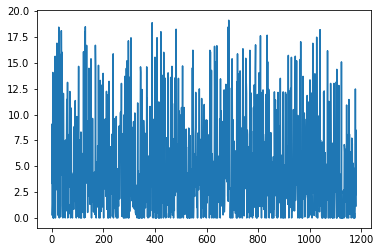

In [128]:
import matplotlib.pyplot as plt
plt.plot(range(regret.shape[0]), regret)
plt.show()

In [117]:
regret_list

[5846.99,
 5616.56,
 5843.610000000001,
 5716.65,
 5887.17,
 5771.1,
 5702.32,
 5654.49,
 5912.860000000001]

In [ ]:
import matplotlib.pyplot as plt

In [111]:
plt.plot()

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]